# ONE TO ONE

/tmp/ipykernel_51124/3085265776.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks)


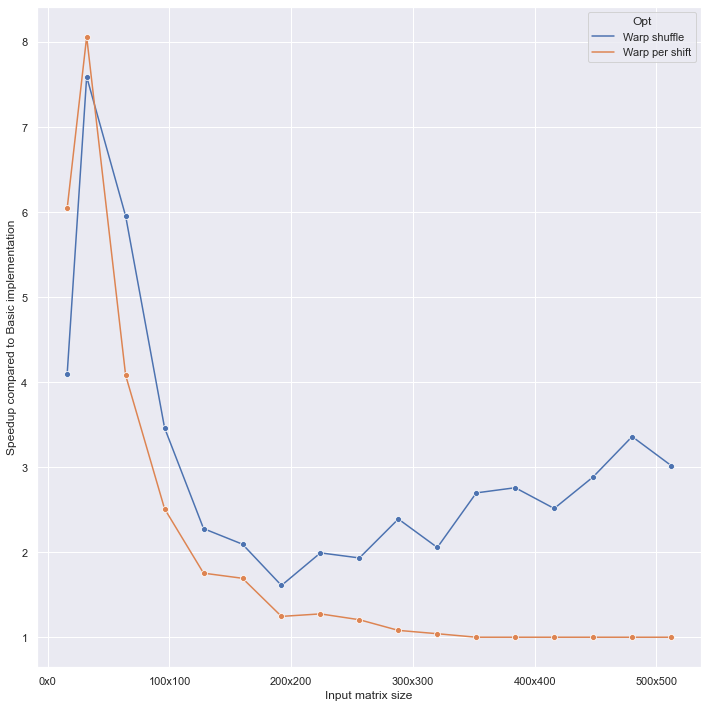

In [27]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark, Run, Group, InputSize

from pathlib import Path
from typing import List, Tuple, Dict

warp_shuffle_benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "warp_shuffle_optimizations_speedup_gpulab")
warp_per_shift_benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "warp_per_shift_optimizations_speedup_gpulab2")
warp_shuffle_group = warp_shuffle_benchmark.groups["one_to_one"]
warp_per_shift_group = warp_per_shift_benchmark.groups["one_to_one"]



comparison_base_name = "basic"
comparison_base_args = ""
# warp_shuffle_algs_and_args = {
#     "basic": {
#         "": "Basic",
#     },
#     "nai_shuffle_multimat_right": {
#         "": "Simple",
#     },
#     "nai_shuffle_multimat_right_work_distribution": {
#         "": "Simple with work distribution",
#
#     },
#     "nai_shuffle_multirow_right": {
#         "4": "Multirow right with 4 overlaps",
#         "8": "Multirow right with 8 overlaps",
#     },
#     "nai_shuffle_multirow_both": {
#         "4": "Multirow both with 4 overlaps",
#         "8": "Multirow both with 8 overlaps"
#     },
# }

def get_max_speedup(group: Group):
    data = pd.concat([run.data for run in group.runs], axis=0, ignore_index=True)
    grouped = data.groupby(["Name", "Args", "Input matrix rows"])



    kernel_times = grouped["Kernel"].mean() / 1e9
    kernel_times.name = "Kernel time"
    results = kernel_times.reset_index()

    comparison_base_times = results[(results["Name"] == comparison_base_name) & (results["Args"] == comparison_base_args)]

    def speedup(row):
        min_time = comparison_base_times[comparison_base_times["Input matrix rows"] == row["Input matrix rows"]]["Kernel time"].item()
        return min_time / row["Kernel time"]

    # def map_name(row):
    #     return warp_shuffle_algs_and_args[row["Name"]][row["Args"]]

    results["Speedup"] = results.apply(speedup, axis=1)
    # results["Implementation"] = results.apply(map_name, axis=1)
    return results.groupby("Input matrix rows")["Speedup"].max().to_frame().reset_index()

warp_shuffle_speedup = get_max_speedup(warp_shuffle_group)
warp_shuffle_speedup["Opt"] = "Warp shuffle"
warp_per_shift_speedup = get_max_speedup(warp_per_shift_group)
warp_per_shift_speedup["Opt"] = "Warp per shift"

input_sizes = [16, 32, 64, 96, 128, 160, 192, 224, 256, 288, 320, 352, 384, 416, 448, 480, 512]

warp_shuffle_speedup = warp_shuffle_speedup[warp_shuffle_speedup["Input matrix rows"].isin(input_sizes)]

warp_per_shift_speedup = warp_per_shift_speedup[warp_per_shift_speedup["Input matrix rows"].isin(input_sizes)]


results = pd.concat([warp_shuffle_speedup, warp_per_shift_speedup]).reset_index()

sns.set(rc={'figure.figsize': (10, 10)})
fig, ax = plt.subplots()



ax = sns.lineplot(data=results, x="Input matrix rows", y="Speedup", hue="Opt", marker='o', ax=ax)
ticks = ax.get_xticks()
ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
ax.set_xticklabels(ticks)
ax.set_xlabel("Input matrix size")
ax.set_ylabel(f"Speedup compared to Basic implementation")
fig.tight_layout()
#fig.savefig("warp_shuffle_against_basic.svg", format="svg")

# sns.set(rc={'figure.figsize': (10, 10)})
# fig, ax = plt.subplots()

# results = results[results["Input matrix rows"] <= 512 ]
#
# ax = sns.lineplot(data=results, x="Input matrix rows", y="Speedup", hue="Implementation", marker='o', ax=ax)
# ticks = ax.get_xticks()
# ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
# ax.set_xticklabels(ticks)
# ax.set_xlabel("Input matrix size")
# ax.set_ylabel(f"Speedup compared to {warp_shuffle_algs_and_args[comparison_base_name][comparison_base_args]} implementation")
# fig.tight_layout()

# ONE TO MANY

/tmp/ipykernel_51124/1378394000.py:81: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks)


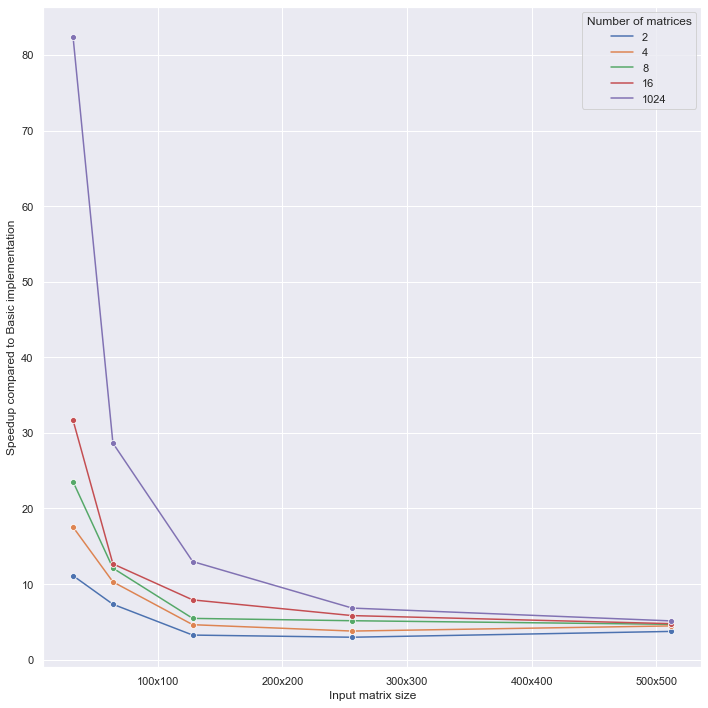

In [28]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark, Run, Group, InputSize

from pathlib import Path
from typing import List, Tuple, Dict

benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "warp_shuffle_optimizations_speedup_gpulab")

group = benchmark.groups["one_to_many"]

comparison_base_name = "basic"
comparison_base_args = ""
# warp_shuffle_algs_and_args = {
#     # "basic": {
#     #     "": "Basic",
#     # },
#     "nai_shuffle_base": {
#         "": "Simple",
#     },
#     "nai_shuffle_multimat_right": {
#         "2": "Multimat right with 2 matrices",
#         "8": "Multimat right with 8 matrices"
#     },
#     "nai_shuffle_multimat_right_work_distribution": {
#         "": "Multimat right with work distribution"
#     },
#     "nai_shuffle_multirow_right_multimat_right": {
#         "": "Multirow right multimat right"
#     },
#     "nai_shuffle_multirow_both_multimat_right": {
#         "": "Multirow both multimat right"
#     },
#     "nai_warp_per_shift_shared_mem": {
#         "": "Warp per shift with shared memory"
#     },
# }

data = pd.concat([run.data for run in group.runs], axis=0, ignore_index=True)

# def filter_data(row) -> bool:
#     return row["Name"] in warp_shuffle_algs_and_args and row["Args"] in warp_shuffle_algs_and_args[row["Name"]]

# data = data[data[["Name", "Args"]].apply(filter_data, axis=1)]

grouped = data.groupby(["Name", "Args", "Input right matrices", "Input matrix rows"])

kernel_times = grouped["Kernel"].mean() / 1e9
kernel_times.name = "Kernel time"
results = kernel_times.reset_index()

comparison_base_times = results[(results["Name"] == comparison_base_name) & (results["Args"] == comparison_base_args)]

def speedup(row):
    min_time = comparison_base_times[(comparison_base_times["Input right matrices"] == row["Input right matrices"]) & (comparison_base_times["Input matrix rows"] == row["Input matrix rows"])]["Kernel time"].item()
    return min_time / row["Kernel time"]

# def map_name(row):
#     return warp_shuffle_algs_and_args[row["Name"]][row["Args"]]

results["Speedup"] = results.apply(speedup, axis=1)
# results["Implementation"] = results.apply(map_name, axis=1)

results = results.groupby(["Input matrix rows", "Input right matrices"])["Speedup"].max().to_frame().reset_index()

palette = dict(zip(results["Input right matrices"].unique(), sns.color_palette(n_colors=results["Input right matrices"].nunique())))


sns.set(rc={'figure.figsize': (10, 10)})

fig, ax = plt.subplots()

ax = sns.lineplot(data=results, x="Input matrix rows", y="Speedup", hue="Input right matrices", marker='o', palette=palette, ax=ax)
ticks = ax.get_xticks()
ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
ax.set_xticklabels(ticks)
ax.set_xlabel("Input matrix size")
ax.set_ylabel(f"Speedup compared to Basic implementation")
legend = ax.get_legend()
legend.set_title("Number of matrices")
fig.tight_layout()



# results = results[results["Input right matrices"] < 1024]

# for input_rows in sorted(results["Input matrix rows"].unique()):
#     sns.set(rc={'figure.figsize': (10, 10)})
#     fig, ax = plt.subplots()
#     r_row_results = results[results["Input matrix rows"] == input_rows]
#     ax = sns.lineplot(data=r_row_results, x="Input right matrices", y="Speedup", hue="Implementation", marker='o', ax=ax)
#     # ticks = ax.get_xticks()
#     # ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
#     # ax.set_xticklabels(ticks)
#     ax.set_xlabel("Input right matrices")
#     ax.set_ylabel(f"Speedup compared to {warp_shuffle_algs_and_args[comparison_base_name][comparison_base_args]} implementation")
#     ax.set_title(f"{input_rows} input rows")
#     fig.tight_layout()

# N TO MN

/tmp/ipykernel_51124/1947695522.py:81: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks)


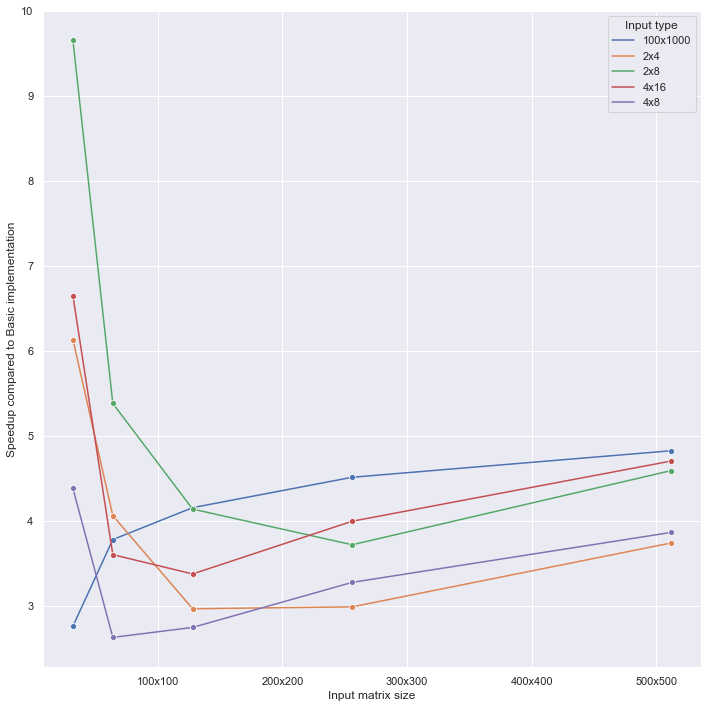

In [11]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark, Run, Group, InputSize

from pathlib import Path
from typing import List, Tuple, Dict

benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "warp_shuffle_optimizations_speedup_gpulab")

group = benchmark.groups["n_to_mn"]

comparison_base_name = "basic"
comparison_base_args = ""
# warp_shuffle_algs_and_args = {
#     # "basic": {
#     #     "": "Basic",
#     # },
#     "nai_shuffle_base": {
#         "": "Simple",
#     },
#     "nai_shuffle_work_distribution": {
#         "": "Simple with work distribution"
#     },
#     "nai_shuffle_multimat_right": {
#         "": "Multimat right"
#     },
#     "nai_shuffle_multimat_right_work_distribution": {
#         "": "Multimat right with work distribution"
#     },
#     "nai_shuffle_multirow_right_multimat_right": {
#         "": "Multirow right multimat right"
#     },
#     "nai_shuffle_multirow_both_multimat_right": {
#         "": "Multirow both multimat right"
#     },
#     # "nai_warp_per_shift_shared_mem": {
#     #     "": "Warp per shift with shared memory"
#     # },
# }

data = pd.concat([run.data for run in group.runs], axis=0, ignore_index=True)

# def filter_data(row) -> bool:
#     return row["Name"] in warp_shuffle_algs_and_args and row["Args"] in warp_shuffle_algs_and_args[row["Name"]]
#
# data = data[data[["Name", "Args"]].apply(filter_data, axis=1)]

grouped = data.groupby(["Name", "Args", "Input type", "Input matrix rows"])

kernel_times = grouped["Kernel"].mean() / 1e9
kernel_times.name = "Kernel time"
results = kernel_times.reset_index()

comparison_base_times = results[(results["Name"] == comparison_base_name) & (results["Args"] == comparison_base_args)]

def speedup(row):
    min_time = comparison_base_times[(comparison_base_times["Input type"] == row["Input type"]) & (comparison_base_times["Input matrix rows"] == row["Input matrix rows"])]["Kernel time"].item()
    return min_time / row["Kernel time"]

# def map_name(row):
#     return warp_shuffle_algs_and_args[row["Name"]][row["Args"]]

results["Speedup"] = results.apply(speedup, axis=1)
# results["Implementation"] = results.apply(map_name, axis=1)

results = results.groupby(["Input matrix rows", "Input type"])["Speedup"].max().to_frame().reset_index()


sns.set(rc={'figure.figsize': (10, 10)})


fig, ax = plt.subplots()
ax = sns.lineplot(data=results, x="Input matrix rows", y="Speedup", hue="Input type", marker='o', ax=ax)
ticks = ax.get_xticks()
ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
ax.set_xticklabels(ticks)
ax.set_xlabel("Input matrix size")
ax.set_ylabel(f"Speedup compared to Basic implementation")
legend = ax.get_legend()
legend.set_title("Number of matrices")
fig.tight_layout()
#fig.savefig("warp_shuffle_against_basic.svg", format="svg")

# results = results[results["Input right matrices"] < 1024]

# for input_rows in sorted(results["Input matrix rows"].unique()):
#     sns.set(rc={'figure.figsize': (10, 10)})
#     fig, ax = plt.subplots()
#     r_row_results = results[results["Input matrix rows"] == input_rows]
#     ax = sns.lineplot(data=r_row_results, x="Input right matrices", y="Speedup", hue="Implementation", marker='o', ax=ax)
#     # ticks = ax.get_xticks()
#     # ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
#     # ax.set_xticklabels(ticks)
#     ax.set_xlabel("Input right matrices")
#     ax.set_ylabel(f"Speedup compared to {warp_shuffle_algs_and_args[comparison_base_name][comparison_base_args]} implementation")
#     ax.set_title(f"{input_rows} input rows")
#     fig.tight_layout()

# N TO M

/tmp/ipykernel_51124/1411107827.py:83: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks)


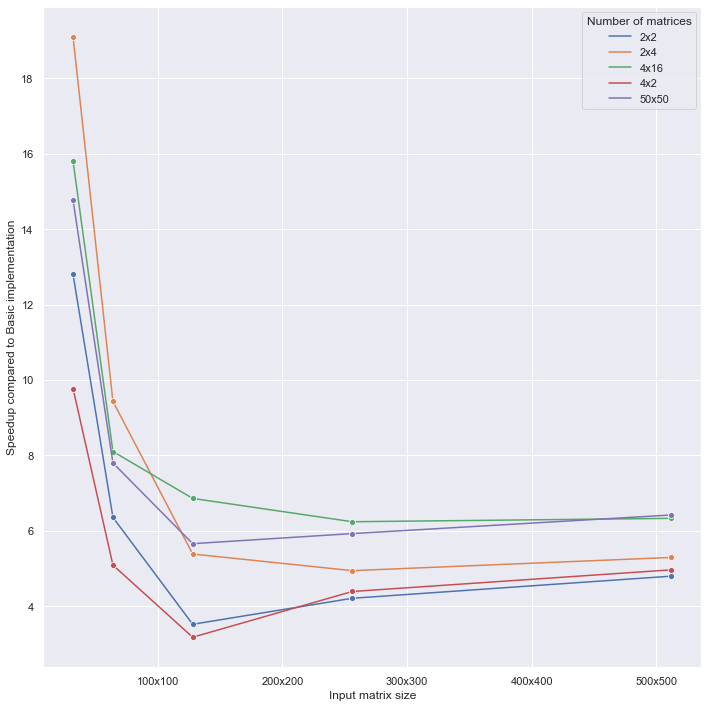

In [13]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark, Run, Group, InputSize

from pathlib import Path
from typing import List, Tuple, Dict

benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "warp_shuffle_optimizations_speedup_gpulab")

group = benchmark.groups["n_to_m"]

comparison_base_name = "basic"
comparison_base_args = ""
# warp_shuffle_algs_and_args = {
#     # "basic": {
#     #     "": "Basic",
#     # },
#     "nai_shuffle_base": {
#         "": "Simple",
#     },
#     "nai_shuffle_multimat_right": {
#         "": "Multimat right"
#     },
#     "nai_shuffle_multimat_right_work_distribution": {
#         "": "Multimat right with work distribution"
#     },
#     "nai_shuffle_multimat_both": {
#         "": "Multimat both"
#     },
#     "nai_shuffle_multimat_both_work_distribution": {
#         "": "Multimat both with work distribution"
#     },
#     "nai_shuffle_multirow_both_multimat_both": {
#         "": "Multirow both multimat both with 2 2"
#     },
#     "nai_shuffle_multirow_both_multimat_both_large": {
#         "": "Multirow both multimat both with 4 4"
#     },
#     # "nai_warp_per_shift_shared_mem": {
#     #     "": "Warp per shift with shared memory"
#     # },
# }

data = pd.concat([run.data for run in group.runs], axis=0, ignore_index=True)

# def filter_data(row) -> bool:
#     return row["Name"] in warp_shuffle_algs_and_args and row["Args"] in warp_shuffle_algs_and_args[row["Name"]]
#
# data = data[data[["Name", "Args"]].apply(filter_data, axis=1)]

grouped = data.groupby(["Name", "Args", "Input type", "Input matrix rows"])

kernel_times = grouped["Kernel"].mean() / 1e9
kernel_times.name = "Kernel time"
results = kernel_times.reset_index()

comparison_base_times = results[(results["Name"] == comparison_base_name) & (results["Args"] == comparison_base_args)]

def speedup(row):
    min_time = comparison_base_times[(comparison_base_times["Input type"] == row["Input type"]) & (comparison_base_times["Input matrix rows"] == row["Input matrix rows"])]["Kernel time"].item()
    return min_time / row["Kernel time"]

# def map_name(row):
#     return warp_shuffle_algs_and_args[row["Name"]][row["Args"]]

results["Speedup"] = results.apply(speedup, axis=1)
# results["Implementation"] = results.apply(map_name, axis=1)

results = results.groupby(["Input matrix rows", "Input type"])["Speedup"].max().to_frame().reset_index()

sns.set(rc={'figure.figsize': (10, 10)})


fig, ax = plt.subplots()
ax = sns.lineplot(data=results, x="Input matrix rows", y="Speedup", hue="Input type", marker='o', ax=ax)
ticks = ax.get_xticks()
ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
ax.set_xticklabels(ticks)
ax.set_xlabel("Input matrix size")
ax.set_ylabel(f"Speedup compared to Basic implementation")
legend = ax.get_legend()
legend.set_title("Number of matrices")
fig.tight_layout()